In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys

print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [4]:
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import os.path
import numpy as np

import matplotlib.pyplot as plt


import housemaze_trainer as trainer
import housemaze
from housemaze import levels
from housemaze import utils
from housemaze import renderer
from housemaze.env import KeyboardActions
from housemaze.human_dyna import multitask_env
from housemaze.human_dyna import mazes
from housemaze.human_dyna import sf_task_runner

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.
/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [5]:
# rendering fns
def display_image(image):
  # Create a new figure and axis
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image)

  # Remove the axis ticks and labels
  ax.axis("off")

  # Show the plot
  plt.tight_layout()
  plt.show()


def render_timestep(timestep):
  image = renderer.create_image_from_grid(
    timestep.state.grid,
    timestep.state.agent_pos,
    timestep.state.agent_dir,
    image_dict,
  )
  plt.imshow(image)
  plt.show()

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl


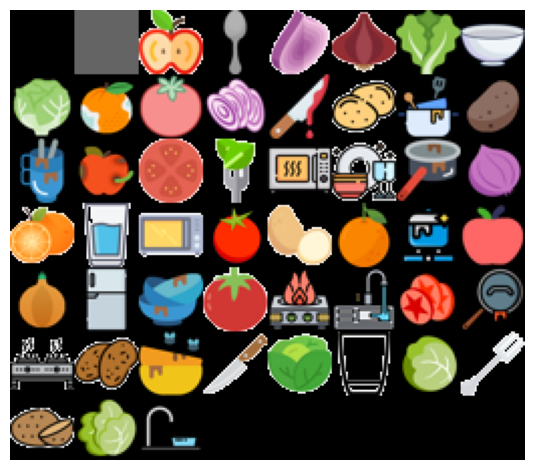

((224, 256, 3),
 ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked'])

In [6]:
# load images and display them
image_dict = utils.load_image_dict()
image = renderer.create_image_grid_from_image_tensor(image_dict["images"], max_cols=8)
display_image(image)
image.shape, image_dict["keys"][:5]

In [7]:
char2idx, groups, task_objects = mazes.get_group_set(2)
task_runner = multitask_env.TaskRunner(task_objects=task_objects)

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


In [8]:
task_objects = groups.reshape(-1)
task_objects

array([26, 40, 47, 43], dtype=int32)

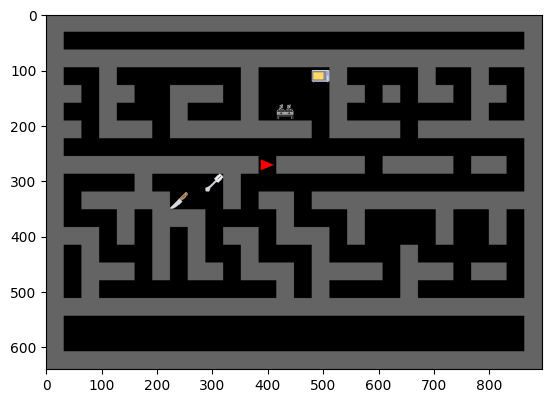

Array([0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.05], dtype=float32)

In [38]:
def get_params(maze_str: str = None):
  maze_str = maze_str or mazes.maze0
  return mazes.get_maze_reset_params(
    groups=groups,
    char2key=char2idx,
    maze_str=maze_str,
    randomize_agent=False,
    make_env_params=True,
  )


# env_params = get_params(mazes.big_test_level)
# task_actions = [
#     KeyboardActions.up,
#     KeyboardActions.up,
#     KeyboardActions.up,
#     KeyboardActions.right,
# ]
env_params = get_params(mazes.big_practice_maze)
task_actions = [
  KeyboardActions.down,
  KeyboardActions.left,
  KeyboardActions.down,
  KeyboardActions.down,
  KeyboardActions.left,
  KeyboardActions.left,
  KeyboardActions.up,
  KeyboardActions.left,
  KeyboardActions.left,
]

seed = 7
rng = jax.random.PRNGKey(seed)

task_runner = sf_task_runner.TaskRunner(
  task_objects=task_objects,
  radius=5,
)
env = multitask_env.HouseMaze(
  task_runner=task_runner,
  num_categories=len(image_dict["keys"]),
)
env = utils.AutoResetWrapper(env)

reset = jax.jit(env.reset)
reset_timestep = reset(rng, env_params)
render_timestep(reset_timestep)
reset_timestep.observation.state_features

features: [0.   0.   0.   0.   0.   0.05 0.05 0.05] | discount: 1.0 | reward: 0.0


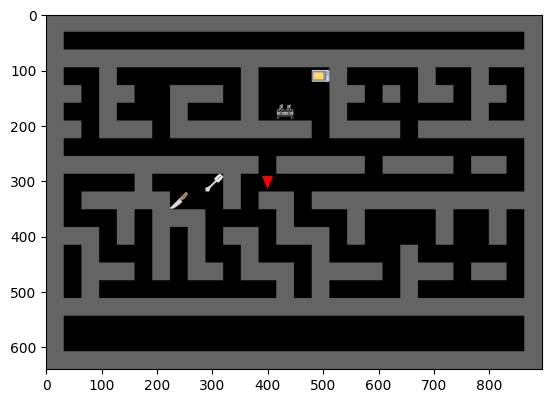

features: [0.   0.   0.   0.   0.   0.05 0.05 0.05] | discount: 1.0 | reward: 0.0


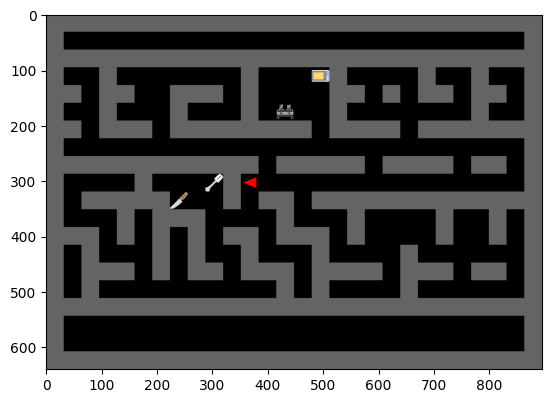

features: [0.   0.   0.   0.   0.   0.05 0.05 0.05] | discount: 1.0 | reward: 0.0


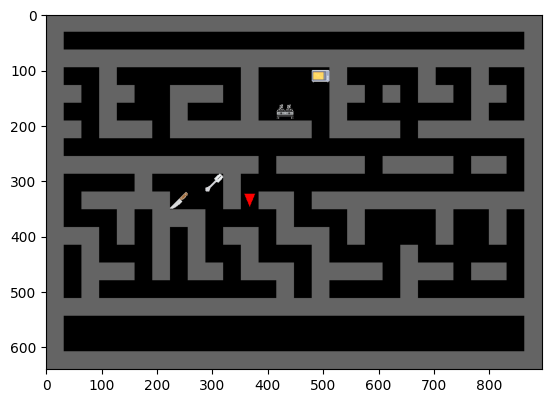

features: [0.   0.   0.   0.   0.   0.   0.05 0.05] | discount: 1.0 | reward: 0.0


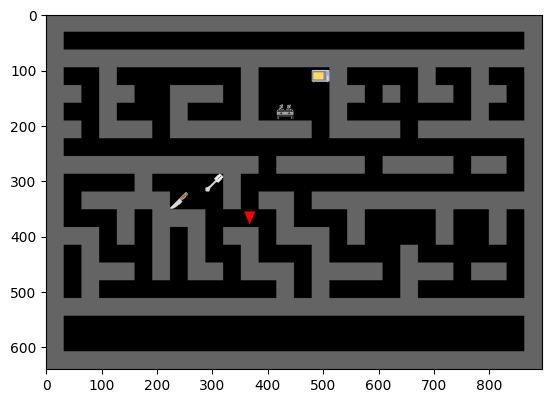

features: [0.   0.   0.   0.   0.   0.   0.05 0.05] | discount: 1.0 | reward: 0.0


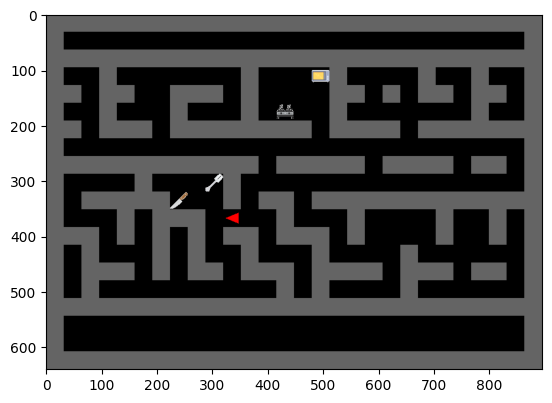

features: [0.   0.   0.   0.   0.   0.   0.05 0.05] | discount: 1.0 | reward: 0.0


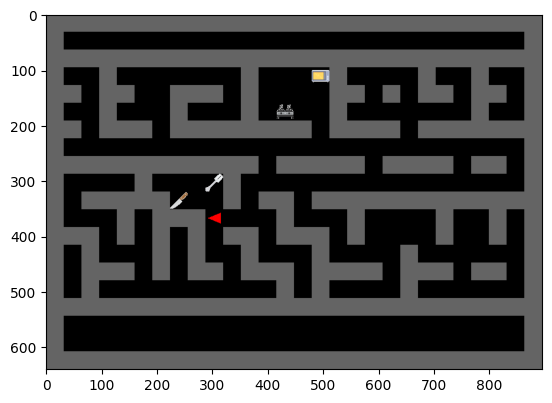

features: [0.   0.   0.   0.   0.   0.05 0.05 0.05] | discount: 1.0 | reward: 0.0


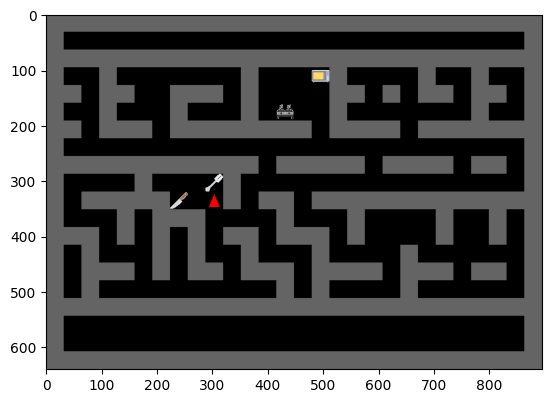

features: [0.   0.   0.   0.   0.   0.05 0.05 0.05] | discount: 1.0 | reward: 0.0


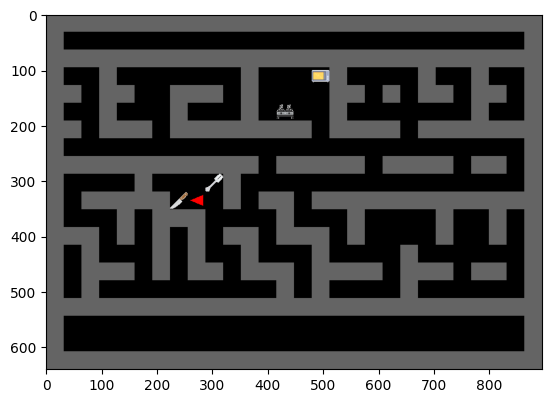

features: [0.   0.   0.   1.   0.   0.   0.05 0.  ] | discount: 0.0 | reward: 0.0


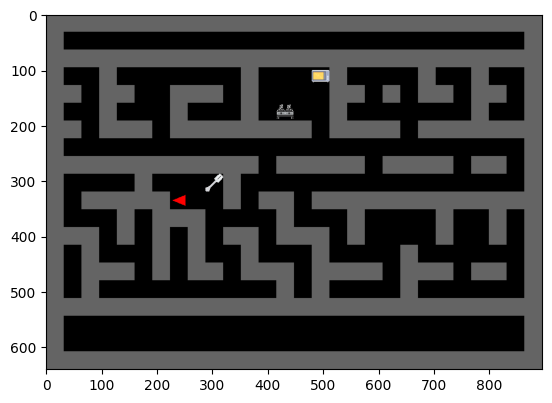

In [42]:
# test that
timestep = reset_timestep

for a in task_actions:
  timestep = env.step(rng, timestep, a, env_params)
  print(
    "features:",
    timestep.observation.state_features,
    "| discount:",
    timestep.discount,
    "| reward:",
    timestep.reward,
  )
  render_timestep(timestep)